In [47]:
import os
import pathlib
import IPython
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display as ld
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.image import resize

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from matplotlib import cm

%load_ext tensorboard

tf.config.list_physical_devices()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [48]:
# Define your folder structure
data_dir = 'queenless'
classes = ['no_queen', 'queen']

def load_data(data_dir, classes): 
    data = []
    labels = []
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                data.append([audio_data, sample_rate])
                labels.append(i)
    
    return data, np.array(labels)

def preprocess_item(y, sr, target_shape=(128, 128)):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    return mel_spectrogram

def preprocess_data(data, target_shape=(128, 128)):
    spectrograms = []
    for d in data:
        audio_data = d[0]
        sample_rate = d[1]
        spectrograms.append(preprocess_item(audio_data, sample_rate, target_shape))
    return np.array(spectrograms)

data, labels = load_data(data_dir, classes)
print(f"Got {len(data)} items")

Got 982 items


In [33]:
def plot_audio(audio, sr):
	n_fft = 2048
	# ft = np.abs(librosa.stft(example_audio[:n_fft], hop_length = n_fft+1))
	# plt.plot(ft)
	# plt.title('Spectrum')
	# plt.xlabel('Frequency Bin')
	# plt.ylabel('Amplitude')

	plt.figure(figsize=(20, 4))

	plt.subplot(1, 3, 1)
	ft = np.abs(librosa.stft(audio[:n_fft], hop_length = n_fft+1))
	plt.plot(ft)
	plt.title('Spectrum')
	plt.xlabel('Frequency Bin')
	plt.ylabel('Amplitude')

	plt.subplot(1, 3, 2)
	X = librosa.stft(audio)
	s = librosa.amplitude_to_db(abs(X))
	ld.specshow(s, sr=sr, x_axis = 'time', y_axis='linear')
	plt.colorbar()

	melspectrum = librosa.feature.melspectrogram(y=audio, sr = sr,
												hop_length =512, n_mels = 40)
	librosa.display.specshow(melspectrum, sr=sr, x_axis='time', y_axis='mel')

	plt.subplot(1, 3, 3)
	X = librosa.stft(audio)
	s = librosa.amplitude_to_db(abs(X))
	ld.specshow(s, sr=sr, x_axis = 'time', y_axis='linear')
	plt.colorbar()
	plt.title('Mel spectrogram')
	plt.tight_layout()

	plt.figure(figsize=(12,4))
	ld.waveshow(audio, sr=sr, color='b')

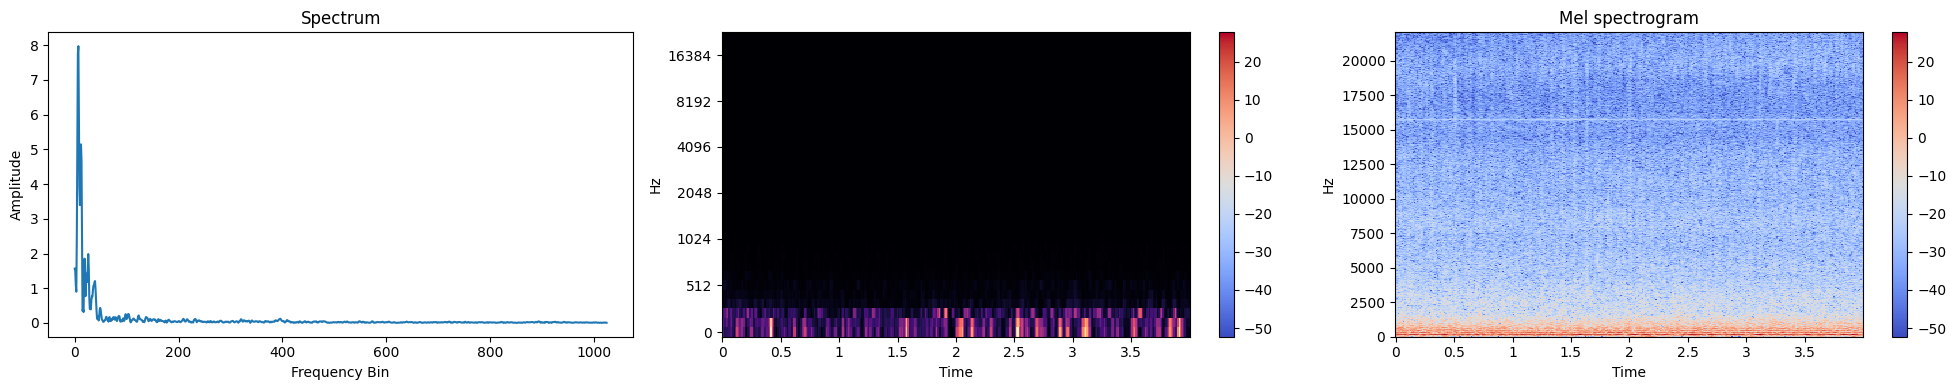

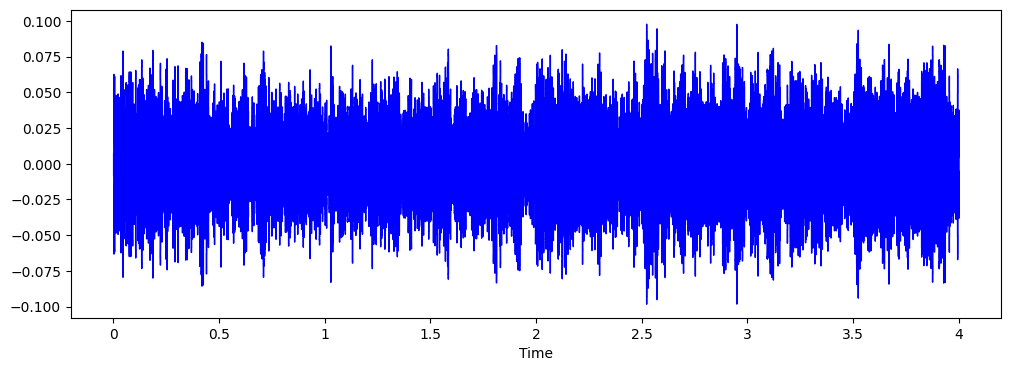

In [34]:
example = data[0]
example_audio = example[0]
example_sr = example[1]
display(IPython.display.Audio(example_audio, rate = example_sr))
plot_audio(example_audio, example_sr)

In [37]:
data = preprocess_data(data)

In [38]:
# Split data into training and testing sets
# data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [39]:
# Create a neural network model
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/100


2024-02-05 23:21:40.732248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-05 23:21:40.763325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


25/25 [==============================] - 5s 66ms/step - loss: 0.9194 - accuracy: 0.5325 - val_loss: 0.8145 - val_accuracy: 0.5228
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.6042 - accuracy: 0.6841 - val_loss: 0.5581 - val_accuracy: 0.8680
Epoch 3/100
25/25 [==============================] - 1s 24ms/step - loss: 0.5052 - accuracy: 0.8178 - val_loss: 0.4792 - val_accuracy: 0.8731
Epoch 4/100
25/25 [==============================] - 1s 24ms/step - loss: 0.4333 - accuracy: 0.8892 - val_loss: 0.3822 - val_accuracy: 0.8782
Epoch 5/100
25/25 [==============================] - 1s 24ms/step - loss: 0.3551 - accuracy: 0.9274 - val_loss: 0.3026 - val_accuracy: 0.9391
Epoch 6/100
25/25 [==============================] - 1s 24ms/step - loss: 0.2806 - accuracy: 0.9554 - val_loss: 0.2507 - val_accuracy: 0.9492
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.2341 - accuracy: 0.9541 - val_loss: 0.2187 - val_accuracy: 0.9442
Epoch 8/100
25/25 

In [42]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9644669890403748
